11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 117.0061 - val_loss: 116.4520
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 114.0575 - val_loss: 116.3526
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 113.5224 - val_loss: 116.3110
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 113.9282 - val_loss: 116.2836
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 112.6939 - val_loss: 116.2821
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 113.2899 - val_loss: 116.2760
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 113.7244 - val_loss: 116.2704
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 113.4340 - val_loss: 116.2694
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 113.7105 - val_loss: 116.2656
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 112.2701 - val_loss: 116.2595
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 113.7142 - val_loss: 116.2594
Epoch 12/50
23/23 ━

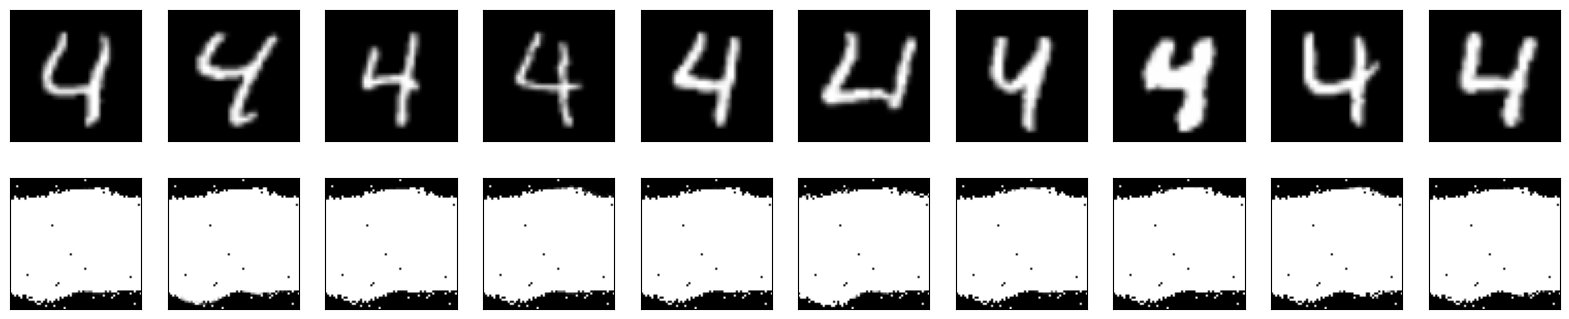

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from skimage.transform import radon

# بارگذاری مجموعه داده MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# تبدیل داده‌ها به نوع float32 و نرمال‌سازی مقادیر به بازه [۰, ۱]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# فیلتر کردن تصاویر عدد ۴ در داده‌های آموزشی و تست
x_train_4 = x_train[y_train == 4]
x_test_4 = x_test[y_test == 4]

# تغییر اندازه تصاویر به 64×64 پیکسل
x_train_4 = tf.image.resize(x_train_4[..., np.newaxis], [64, 64]).numpy()
x_test_4 = tf.image.resize(x_test_4[..., np.newaxis], [64, 64]).numpy()

# اعمال تبدیل رادن به تصاویر
theta = np.linspace(0., 180., max(x_train_4.shape[1:3]), endpoint=False)
x_train_radon_4 = np.array([radon(x_train_4[i].reshape(64, 64), theta=theta) for i in range(x_train_4.shape[0])])
x_test_radon_4 = np.array([radon(x_test_4[i].reshape(64, 64), theta=theta) for i in range(x_test_4.shape[0])])

# تبدیل تصاویر به بردارهای تخت شده
x_train_radon_flat_4 = x_train_radon_4.reshape(x_train_radon_4.shape[0], -1)
x_test_radon_flat_4 = x_test_radon_4.reshape(x_test_radon_4.shape[0], -1)

# تعریف مدل L-SVD
input_dim = x_train_radon_flat_4.shape[1]
latent_dim = 64  # ابعاد فضای لاتنت

# انکودر
inputs = Input(shape=(input_dim,))
encoded = Dense(latent_dim, activation='relu')(inputs)

# ماتریس Σ (قطری)
sigma = np.random.randn(latent_dim)
sigma_diag = np.diag(sigma)

# دیکودر
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# مدل L-SVD
autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

# کامپایل مدل
autoencoder.compile(optimizer='adam', loss='mse')

# آموزش مدل
autoencoder.fit(x_train_radon_flat_4, x_train_radon_flat_4,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_radon_flat_4, x_test_radon_flat_4))

# بازسازی داده‌های تست
encoded_imgs = encoder.predict(x_test_radon_flat_4)
decoded_imgs = autoencoder.predict(x_test_radon_flat_4)

# نمایش نتایج
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # نمایش تصویر اصلی
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_4[i].reshape(64, 64), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # نمایش تصویر بازسازی شده
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()